<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/DQN_Reinforcement_Learning_on_GYM_Atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Pretrained Model
This model is only trained to play Pong

To keep Colab from timeout, Press F12 and paste the following JavaScript code the the console.

```JavaScript
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

# Colab Installs + Regular Imports
If you're running this script outside of a notebook set Colab to 'False'
gsync allows this notebook to save pretrained models directly to your Google Drive account

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=d696e40f93f0ec21009cf87c8b6d88b1d1a99365656623ee17e43e74de119f30
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 155.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install torchviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (1,087 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for torchviz: fil

In [0]:
# Google Colab PyTorch utilities

import time
import numpy as np
import collections
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gym
import gym.spaces
from torchsummary import summary
from torchviz import make_dot

In [0]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))

device is cuda


### Mount Google Drive to save/load model weights (Optional)
It is time consuming to train reinforcement learning, even for such a simple game. Colab only gives us 12 hr of usage. Although it is enough for game like Breakout, we still want to save the model weight somewhere eles in case we want to do a hot restart. The simplest solution is to mount your google drive and save the model weight there. It is completely optional.

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Configurations

Parameters
* REPLAY_SIZE: Maximum number of experiences stored in replay memory
* TARGET_UPDATE_FREQ: How many frames in between syncing target DQN with behaviour DQN
* LEARNING_STARTS: Number of experiences to add to replay memory before training network

In [0]:
# ENV_NAME = "PongNoFrameskip-v4"
# MODEL = "PretrainedModels/PongNoFrameskip-v4-407.dat"
ENV_NAME = "BreakoutNoFrameskip-v4"
MODEL = "BreakoutNoFrameskip-v4.dat"
GDRIVE_FOLDER = "BreakoutModels"

MEAN_REWARD_BOUND = 50

FRAME_SKIPPING = 8

GAMMA = 0.95
BATCH_SIZE = 32
REPLAY_SIZE = 10 ** 5 * 2
LEARNING_STARTS = 10**4 * 2

LEARNING_RATE = 1e-5
TARGET_UPDATE_FREQ = 10000

EPSILON_DECAY = 10**5 * 5
EPSILON_START = 0.9
EPSILON_FINAL = 0.1

MODEL_SAVE_STEP = 200 

LOAD_MODEL_NAME = 'BreakoutNoFrameskip-v4-8600.dat' #set to null if cold start

In [0]:
SAVE_FOLDER = os.path.join('/content/drive/My Drive/',GDRIVE_FOLDER)
if (not os.path.isdir(SAVE_FOLDER)):
    os.mkdir(SAVE_FOLDER)

# OpenAI Gym Wrappers
These wrappers make it easier to interact with OpenAI Gym

Wrappers include:


*   Frame skipping
*   Frame processing (downsampling and greyscaling)
* Image normalization and converting to PyTorch



In [0]:
# Taken from OpenAI baseline wrappers
# https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        print(env.unwrapped.get_action_meanings())
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env_name, frame_skip):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env,skip = frame_skip)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

# DQN Architecture
Deep-Q-Networks (DQNs) are composed of: 
* 3 convolution layers
* 2 fully-connected linear layers

In [0]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Experience Replay

In [0]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

# Agent

In [0]:
class Agent:
    def __init__(self, env, replay_memory):
        self.env = env
        self.replay_memory = replay_memory
        self._reset()
        self.last_action = 0

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        """
        Select action
        Execute action and step environment
        Add state/action/reward to experience replay
        """
        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward
        new_state = new_state

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.replay_memory.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

# Loss function 

In [0]:
def calculate_loss(batch, net, target_net, device="cpu"):
    """
    Calculate MSE between actual state action values,
    and expected state action values from DQN
    """
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done = torch.BoolTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)
    next_state_values = target_net(next_states_v).max(1)[0]
    next_state_values[done] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Training Loop

ReplayMemory will require 45.16gb of GPU RAM
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 512]       1,606,144
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.33
Params size (MB

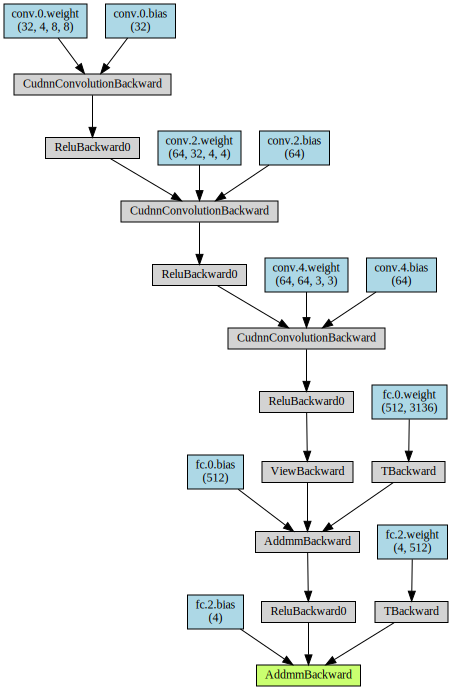

In [47]:
print("ReplayMemory will require {}gb of GPU RAM".format(round(REPLAY_SIZE * 32 * 84 * 84 / 1e+9, 2)))
class ColabArgParse():
    def __init__(self, cuda, env, reward, model):
        self.cuda = cuda
        self.env = env
        self.reward = reward
        self.model = model

args = ColabArgParse(device, ENV_NAME, MEAN_REWARD_BOUND, MODEL)

env = make_env(args.env, frame_skip = FRAME_SKIPPING)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

replay_memory = ExperienceReplay(REPLAY_SIZE)
agent = Agent(env, replay_memory)
epsilon = EPSILON_START

summary(net, env.observation_space.shape)
print(net)
make_dot(net(torch.zeros([1,*env.observation_space.shape]).to(device)), params=dict(net.named_parameters()))


In [48]:
if LOAD_MODEL_NAME:
    net.load_state_dict(torch.load(os.path.join(SAVE_FOLDER, LOAD_MODEL_NAME)))
    target_net.load_state_dict(net.state_dict())
    total_rewards = pickle.load(open(os.path.join(SAVE_FOLDER, 'output.pkl'), 'rb'))
    print("Models loaded from Google Drive!")
    # Lower exploration rate IMPORTANT
    EPSILON_START = EPSILON_FINAL
    print(f'Set epsilon start as {EPSILON_START}')


Models loaded from Google Drive!
Set epsilon start as 0.1


In [0]:
def create_animation(net, args, epsilon = 0.05, device = 'cuda', try_num = 10):

    def display_frames_as_gif(frames):
        """
        Displays a list of frames as a gif, with controls
        """
        #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=100)
        rc('animation', html='jshtml')
        return anim

    best_reward, best_frames = -100, None
    for i in range(try_num):
        agent._reset()
        frames = []
        for t in range(1000):
            tmp_reward = agent.play_step(net, epsilon = 0.05, device = device)
            frames.append(agent.env.render(mode = 'rgb_array'))
            if tmp_reward is not None:
                break
        print(f'  --Try {i}: t={t}, reward={tmp_reward}', end = '')
        if tmp_reward is not None and tmp_reward>best_reward:
            best_reward = tmp_reward
            best_frames = frames.copy()
            best_t = t
            print(f' Best reward updated')
        else:
            print()

    print('  --Generating animation..')
    anim = display_frames_as_gif(best_frames)
    print(f' --Animationm from {len(best_frames)} frames with reward {best_reward} generated')
    return anim, len(best_frames), best_reward

In [0]:
def save_model_animation(net, args, T):
    torch.save(net.state_dict(), f'{args.env}-{T}.dat')
    torch.save(net.state_dict(), os.path.join(SAVE_FOLDER, f'{args.env}-{T}.dat'))
    pickle.dump(total_rewards,open(os.path.join(SAVE_FOLDER, 'output.pkl'),'wb'))

    anim, t, tot_r = create_animation(net, args, epsilon = 0.05, device = device, try_num=10)

    anim_save_file_name = os.path.join(SAVE_FOLDER, f'{args.env}-{T}-{t}frame_{tot_r}')
    anim.save(f'{anim_save_file_name}.mp4')
    anim.save(f'{anim_save_file_name}.gif', writer='matplotlib.animation.PillowWriter', fps=30)

In [0]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay = 5e-5)

1088 frames: done 3 games, mean reward 26.0,  308 frame/episode, eps 0.1, speed 259.03 f/s
1906 frames: done 6 games, mean reward 22.833,  238 frame/episode, eps 0.1, speed 266.13 f/s
2773 frames: done 9 games, mean reward 22.222,  340 frame/episode, eps 0.1, speed 256.19 f/s
3755 frames: done 12 games, mean reward 21.833,  426 frame/episode, eps 0.1, speed 261.55 f/s
4612 frames: done 15 games, mean reward 23.333,  304 frame/episode, eps 0.1, speed 267.21 f/s
5568 frames: done 18 games, mean reward 23.333,  389 frame/episode, eps 0.1, speed 258.14 f/s
6457 frames: done 21 games, mean reward 23.524,  377 frame/episode, eps 0.1, speed 260.05 f/s
7670 frames: done 24 games, mean reward 24.333,  307 frame/episode, eps 0.1, speed 252.0 f/s
8705 frames: done 27 games, mean reward 24.593,  280 frame/episode, eps 0.1, speed 254.32 f/s
9705 frames: done 30 games, mean reward 24.733,  270 frame/episode, eps 0.1, speed 253.04 f/s
10667 frames: done 33 games, mean reward 25.97,  322 frame/episode

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


63809 frames: done 201 games, mean reward 27.07,  234 frame/episode, eps 0.1, speed 8.46 f/s
64727 frames: done 204 games, mean reward 26.6,  291 frame/episode, eps 0.1, speed 62.76 f/s
65468 frames: done 207 games, mean reward 26.11,  204 frame/episode, eps 0.1, speed 63.46 f/s
66620 frames: done 210 games, mean reward 26.4,  345 frame/episode, eps 0.1, speed 64.59 f/s
67573 frames: done 213 games, mean reward 25.99,  270 frame/episode, eps 0.1, speed 63.36 f/s
68343 frames: done 216 games, mean reward 25.65,  246 frame/episode, eps 0.1, speed 64.36 f/s
69078 frames: done 219 games, mean reward 25.21,  358 frame/episode, eps 0.1, speed 64.18 f/s
70007 frames: done 222 games, mean reward 25.25,  352 frame/episode, eps 0.1, speed 63.53 f/s
70881 frames: done 225 games, mean reward 25.17,  368 frame/episode, eps 0.1, speed 62.96 f/s
71594 frames: done 228 games, mean reward 24.94,  184 frame/episode, eps 0.1, speed 66.03 f/s
72516 frames: done 231 games, mean reward 25.32,  350 frame/epi

KeyboardInterrupt: ignored

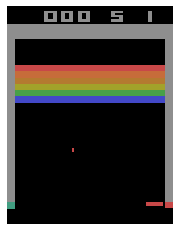

In [56]:
total_rewards = []
best_mean_reward = None
frame_idx = 0
timestep_frame = 0
timestep = time.time()

while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY)

    reward = agent.play_step(net, epsilon, device=device)

    if reward is not None: #episode finished
        total_rewards.append(reward)
        delta_frame = frame_idx - timestep_frame
        speed = delta_frame / (time.time() - timestep)
        timestep_frame = frame_idx
        timestep = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        if (len(total_rewards)%3==0):
            print(f"{frame_idx} frames: done {len(total_rewards)} games, mean reward {round(mean_reward,3)}, ",
                    f"{delta_frame:3d} frame/episode, eps {round(epsilon,3)}, speed {round(speed,2)} f/s")

        #if (best_mean_reward is None or best_mean_reward < mean_reward) and len(total_rewards) % MODEL_SAVE_STEP == 0:
        if len(total_rewards) % MODEL_SAVE_STEP == 0:
            save_model_animation(net, args, len(total_rewards))
            if best_mean_reward is not None:
                print("New best mean reward {} -> {}, model saved".format(round(best_mean_reward, 3), round(mean_reward, 3)))
            best_mean_reward = mean_reward
        if mean_reward > args.reward and len(total_rewards) > 10:
            print("Game solved in {} frames! Average score of {}".format(frame_idx, mean_reward))
            break

    if len(replay_memory) < LEARNING_STARTS:
        continue

    if frame_idx % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = replay_memory.sample(BATCH_SIZE)
    loss_t = calculate_loss(batch, net, target_net, device=device)
    loss_t.backward()
    optimizer.step()

env.close()


Text(0.5, 1.0, 'Moving average of per episodes reward')

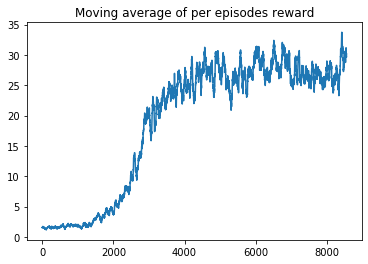

In [23]:
w = 50
plt.plot(np.convolve(np.array(total_rewards), np.ones(w), 'valid') / w)
plt.title('Moving average of per episodes reward')

## Play

In [20]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x400x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x400x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

Try 0: t=387, reward=25.0
  update best reward
Try 1: t=326, reward=42.0
  update best reward
Try 2: t=387, reward=25.0
Try 3: t=387, reward=25.0
Try 4: t=387, reward=25.0
Try 5: t=382, reward=38.0
Try 6: t=567, reward=25.0
Try 7: t=611, reward=25.0
Try 8: t=387, reward=25.0
Try 9: t=310, reward=17.0
generating animationm from 327 frames with reward 42.0


MovieWriter animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


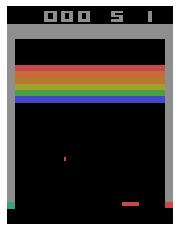

In [38]:
anim, t, tot_r = create_animation(net, args, epsilon = 0.05, device = device, try_num=10)

In [0]:
T=len(total_rewards)
anim_save_file_name = os.path.join(SAVE_FOLDER, f'{args.env}-{T}-{t}frame_{tot_r}')
anim.save(f'{anim_save_file_name}.mp4')
anim.save(f'{anim_save_file_name}.gif', writer='animation.PillowWriter', fps=30)
